<a href="https://colab.research.google.com/github/P202U/Movie_recommend/blob/main/Neural_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

100%|██████████| 4.77M/4.77M [00:00<00:00, 42.7MB/s]

Extracting files...


# **Data loading and preprocessing**

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
ratings_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.item'), sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date',
                              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                              'Thriller', 'War', 'Western'])
movies_df.head()

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {ratings_df['item_id'].nunique()}")
print(f'Number of ratings: {len(ratings_df)}')
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")

Number of users: 943
Number of movies: 1682
Number of ratings: 100000
Rating range: 1 to 5
Average rating: 3.53


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children            1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

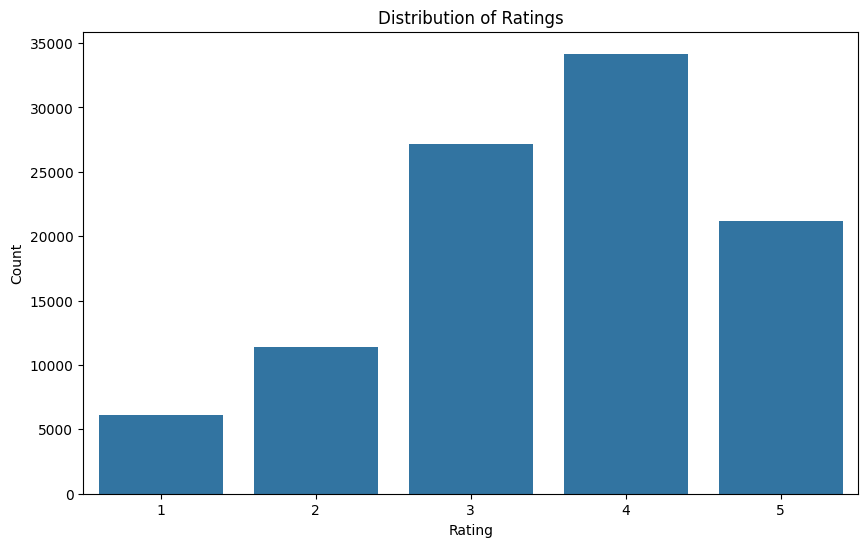

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [9]:
ratings_df['label'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [10]:
ratings_df.sample(5)

,user_id,item_id,rating,timestamp,label
75721,877,381,4,882677345,1
80184,815,602,3,878694269,0
19864,94,431,4,891721716,1
76699,416,875,2,876696938,0
92991,500,182,2,883873556,0


# **Data preparation**

In [11]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Training: {len(train_df)}")
print(f"Test: {len(test_df)}")

Training: 80000
Test: 20000


In [12]:
num_users = ratings_df['user_id'].max()
num_items = ratings_df['item_id'].max()

print(f"Users: {num_users}")
print(f"Items: {num_items}")

Users: 943
Items: 1682


In [13]:
class NCFDataset(Dataset):
  def __init__(self, df):
    self.user_ids = torch.tensor(df['user_id'].values, dtype = torch.long)
    self.item_ids = torch.tensor(df['item_id'].values, dtype = torch.long)
    self.labels = torch.tensor(df['label'].values, dtype = torch.float)

  def __len__(self):
    return len(self.user_ids)

  def __getitem__(self, index):
    return {
        'user_id': self.user_ids[index],
        'item_id': self.item_ids[index],
        'label': self.labels
    }

In [14]:
traindataset = NCFDataset(train_df)
testdataset = NCFDataset(test_df)

In [15]:
batch_size = 256
train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=batch_size, shuffle=False)

In [26]:
class NCF(nn.Module):
  def __init__(self, num_users, num_items, embedding_dim=32, mlp_layers=[32, 64, 16]):
    super(NCF, self).__init__()

    self.user_embedding_gmf = nn.Embedding(num_users + 1, embedding_dim)
    self.item_embedding_gmf = nn.Embedding(num_items + 1, embedding_dim)

    self.user_embedding_mlp = nn.Embedding(num_users + 1, embedding_dim)
    self.item_embedding_mlp = nn.Embedding(num_items + 1, embedding_dim)

    mlp_input_dim = 2 * embedding_dim

    self.mlp_layers = nn.ModuleList()
    for index, layer_size in enumerate(mlp_layers):
      if index == 0:
        self.mlp_layers.append(nn.Linear(mlp_input_dim, layer_size))
      else:
        self.mlp_layers.append(nn.Linear(mlp_layers[index - 1], layer_size))
      self.mlp_layers.append(nn.ReLU())

    self.output_layer = nn.Linear(embedding_dim + mlp_layers[-1], 1)
    self.sigmoid = nn.Sigmoid()

    self._init_weights()

  def _init_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Embedding):
               nn.init.normal_(m.weight, mean=0.0, std=0.01)
        elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          if m.bias is not None:
            nn.init.zeros_(m.bias)

  def forward(self, user_ids, item_ids):
       user_embedding_gmf = self.user_embedding_gmf(user_ids)
       item_embedding_gmf = self.item_embedding_gmf(item_ids)
       gmf_vector = user_embedding_gmf * item_embedding_gmf

       user_embedding_mlp = self.user_embedding_mlp(user_ids)
       item_embedding_mlp = self.item_embedding_mlp(item_ids)
       mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)


       for layer in self.mlp_layers:
           mlp_vector = layer(mlp_vector)

       concat_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)

       prediction = self.sigmoid(self.output_layer(concat_vector)).squeeze()

       return prediction


embedding_dim = 32
mlp_layers = [64, 32, 16]
model = NCF(num_users, num_items, embedding_dim, mlp_layers).to(device)


print(model)

NCF(
  (user_embedding_gmf): Embedding(944, 32)
  (item_embedding_gmf): Embedding(1683, 32)
  (user_embedding_mlp): Embedding(944, 32)
  (item_embedding_mlp): Embedding(1683, 32)
  (mlp_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 70.84it/s]


Epoch 1/10 - Train Loss: 0.0000, Val Loss: 5.8485, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 99.09it/s]


Epoch 2/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 74.12it/s]


Epoch 3/10 - Train Loss: 0.0000, Val Loss: 5.8666, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.26it/s]


Epoch 4/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.27it/s]


Epoch 5/10 - Train Loss: 0.0000, Val Loss: 5.8666, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 54.17it/s]


Epoch 6/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 59.09it/s]


Epoch 7/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 48.02it/s]


Epoch 8/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.18it/s]


Epoch 9/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 51.58it/s]


Epoch 10/10 - Train Loss: 0.0000, Val Loss: 5.8855, AUC: 0.5000, AP: 0.5390


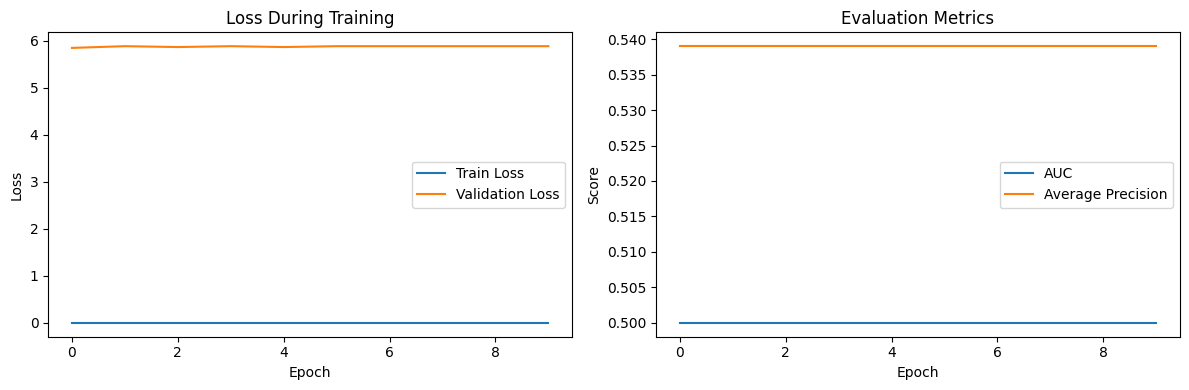

Model saved successfully!


In [34]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


def train_epoch(model, data_loader, criterion, optimizer, device):
   model.train()
   total_loss = 0
   for batch in tqdm(data_loader, desc="Training"):
       user_ids = batch['user_id'].to(device)
       item_ids = batch['item_id'].to(device)
       labels = batch['label'].to(device)

       if labels.ndimension() > 1:
            labels = torch.argmax(labels, dim=-1)

       labels = labels.float().view(-1, 1)

       optimizer.zero_grad()
       outputs = model(user_ids, item_ids)

       loss = criterion(outputs, labels.view(-1))

       loss.backward()
       optimizer.step()

       total_loss += loss.item()

   return total_loss / len(data_loader)


def evaluate(model, data_loader, criterion, device):
   model.eval()
   total_loss = 0
   predictions = []
   true_labels = []

   with torch.no_grad():
       for batch in tqdm(data_loader, desc="Evaluating"):
           user_ids = batch['user_id'].to(device)
           item_ids = batch['item_id'].to(device)
           labels = batch['label'].to(device)

           outputs = model(user_ids, item_ids).view(-1)
           if labels.ndimension() > 1:
               batch_indices = torch.arange(labels.size(0)).to(device)
               labels = labels[batch_indices, item_ids]

           labels = labels.float().view(-1)

           loss = criterion(outputs, labels)
           total_loss += loss.item()

           predictions.extend(outputs.cpu().numpy())
           true_labels.extend(labels.cpu().numpy())

   from sklearn.metrics import roc_auc_score, average_precision_score

   if len(np.unique(true_labels)) < 2:
       print("Warning: Only one class present in true_labels. AUC/AP might be undefined.")
       auc, ap = 0.5, 0.0
   else:
       auc = roc_auc_score(true_labels, predictions)
       ap = average_precision_score(true_labels, predictions)

   return {
       'loss': total_loss / len(data_loader),
       'auc': auc,
       'ap': ap
   }


num_epochs = 10
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_ap': []}


for epoch in range(num_epochs):
   train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

   eval_metrics = evaluate(model, test_loader, criterion, device)

   history['train_loss'].append(train_loss)
   history['val_loss'].append(eval_metrics['loss'])
   history['val_auc'].append(eval_metrics['auc'])
   history['val_ap'].append(eval_metrics['ap'])

   print(f"Epoch {epoch+1}/{num_epochs} - "
         f"Train Loss: {train_loss:.4f}, "
         f"Val Loss: {eval_metrics['loss']:.4f}, "
         f"AUC: {eval_metrics['auc']:.4f}, "
         f"AP: {eval_metrics['ap']:.4f}")


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history['val_auc'], label='AUC')
plt.plot(history['val_ap'], label='Average Precision')
plt.title('Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()


plt.tight_layout()
plt.show()


torch.save(model.state_dict(), 'ncf_model.pth')
print("Model saved successfully!")